In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, mean_absolute_percentage_error

In [2]:
import ast

dict_columns = ['Validation_Base_SimulationRes']

def flatten_columns(result_df, dict_columns):
    for col in dict_columns:
        # Convert string to dict only if needed
        result_df[col] = result_df[col].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
        
        # Expand the dictionary into separate columns
        expanded = result_df[col].apply(pd.Series).add_prefix(f"{col}_")
        
        # Merge into original dataframe
        result_df = result_df.drop(columns=[col]).join(expanded)
    return result_df

In [3]:
test_data = pd.read_excel('../01_DataCollecting/Sim_result/Heat_exchanger_process_data_result_V5-short.xlsx', index_col=0)
test_data.reset_index(drop=True, inplace=True)

In [4]:
# Simulation Cols mapping
cols_mapping = {'InputParams': {'FEED1MASSFLOW': 'C3', 'FEED1TEMP': 'C4','PROD1MASSFLOW': 'C5','PROD1TEMP': 'C6',
                          'E1FOULING': 'C11', 'E2FOULING': 'C15'},
               'OutputParams': {'PROD1E1IN': 'C3', 'PROD1OUT': 'C4', 'FEED1E1OUT': 'C7', 'FEED1OUT': 'C8'},
               'Outputuoms': {'PROD1E1IN': 'C', 'PROD1OUT': 'C', 'FEED1E1OUT': 'C', 'FEED1OUT': 'C'}
               }
# X , y cols sorrend a fontos az ANN-hez majd
x_cols = list(cols_mapping['InputParams'].keys())
y_cols = list(cols_mapping['OutputParams'].keys())

In [5]:
cases_list = [{'CaseName': 'No-Calibration', 'Type':'direct', 'resultfile': '../03_Workflow_Calibration/Results/00_No_Calibration.xlsx'},
              {'CaseName': 'Direct', 'Type':'direct', 'resultfile': '../03_Workflow_Calibration/Results/Direct/01_Calibration_direct.xlsx'},
              
              {'CaseName': 'Surrogate', 'Type':'FNN-low', 'resultfile': '../03_Workflow_Calibration/Results/Surrogate_base/02_Calibration_static_FNN-low.xlsx'},
              {'CaseName': 'Surrogate', 'Type':'FNN-high', 'resultfile': '../03_Workflow_Calibration/Results/Surrogate_base/02_Calibration_static_FNN-high.xlsx'},
              {'CaseName': 'Surrogate', 'Type':'BNN', 'resultfile': '../03_Workflow_Calibration/Results/Surrogate_base/02_Calibration_static_BNN.xlsx'},
              {'CaseName': 'Surrogate', 'Type':'FNN-BNN-low', 'resultfile': '../03_Workflow_Calibration/Results/Surrogate_base/02_Calibration_static_FNN-BNN-low.xlsx'},

              
              {'CaseName': 'Online-always-one', 'Type':'FNN-low', 'resultfile': '../03_Workflow_Calibration/Results/OnlineLearning/03_Calibration_Online_FNN-low_always-one.xlsx'},
              {'CaseName': 'Online-always-one', 'Type':'FNN-high', 'resultfile': '../03_Workflow_Calibration/Results/OnlineLearning/03_Calibration_Online_FNN-high_always-one.xlsx'},
              {'CaseName': 'Online-always-one', 'Type':'FNN-BNN-low', 'resultfile': '../03_Workflow_Calibration/Results/OnlineLearning/03_Calibration_Online_FNN-BNN-low_always-one.xlsx'},
              

              {'CaseName': 'Online-always-both', 'Type':'FNN-low', 'resultfile': '../03_Workflow_Calibration/Results/OnlineLearning/04_Calibration_Online_FNN-low_always-both.xlsx'},
              {'CaseName': 'Online-always-both', 'Type':'FNN-high', 'resultfile': '../03_Workflow_Calibration/Results/OnlineLearning/04_Calibration_Online_FNN-high_always-both.xlsx'},
              {'CaseName': 'Online-always-both', 'Type':'FNN-BNN-low', 'resultfile': '../03_Workflow_Calibration/Results/OnlineLearning/04_Calibration_Online_FNN-BNN-low_always-both.xlsx'},

              {'CaseName': 'Online-conditional', 'Type':'FNN-low', 'resultfile': '../03_Workflow_Calibration/Results/OnlineLearning/05_Calibration_Online_FNN-low_conditional.xlsx'},
              {'CaseName': 'Online-conditional', 'Type':'FNN-high', 'resultfile': '../03_Workflow_Calibration/Results/OnlineLearning/05_Calibration_Online_FNN-high_conditional.xlsx'},
              {'CaseName': 'Online-conditional', 'Type':'FNN-BNN-low', 'resultfile': '../03_Workflow_Calibration/Results/OnlineLearning/05_Calibration_Online_FNN-BNN-low_conditional.xlsx'},


              {'CaseName': 'Online-NoReplay', 'Type':'FNN-low', 'resultfile': '../03_Workflow_Calibration/Results/OnlineLearning/06_Calibration_Online_FNN-low_always-one-noreplay.xlsx'},
              {'CaseName': 'Online-NoReplay', 'Type':'FNN-high', 'resultfile': '../03_Workflow_Calibration/Results/OnlineLearning/06_Calibration_Online_FNN-high_always-one-noreplay.xlsx'},
              {'CaseName': 'Online-NoReplay', 'Type':'FNN-BNN-low', 'resultfile': '../03_Workflow_Calibration/Results/OnlineLearning/06_Calibration_Online_FNN-BNN-low_always-one-noreplay.xlsx'},
              
              ]

## Calibration Validation accuracy cost

C:\Users\pales\AppData\Local\Temp\ipykernel_28264\413339345.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')


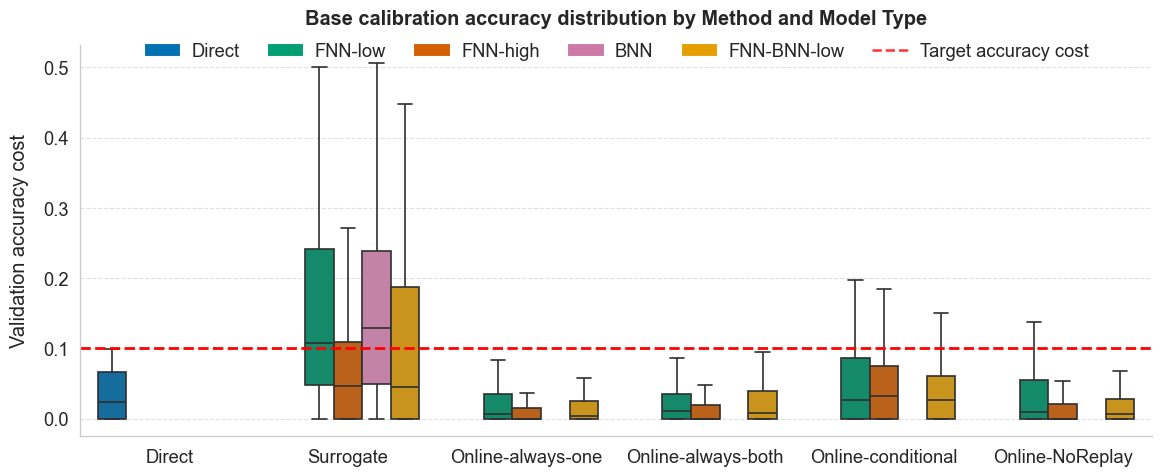

In [6]:
# Collect all costs into a single DataFrame
cost_data = []
for case in cases_list:
    try:
        df = pd.read_excel(case['resultfile'], index_col=0)
        if case['CaseName'] not in ['No-Calibration']:
            for cost in df['Validation_Base_SimCost']:
                cost_data.append({
                    'Case': case['CaseName'],
                    'Model type': case['Type'],
                    'Calibration Cost': cost
                })
    except Exception as e:
        print(f"Could not load {case['resultfile']}: {e}")

cost_df = pd.DataFrame(cost_data)


# Modern style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 5))
sns.set_context("paper", font_scale=1.5)  # good for scientific figures

# Color palette
model_type_palette = {
    'direct': '#0072B2',         # blue
    'FNN-low': '#009E73',  # green
    'FNN-high': '#D55E00',  # orange/red
    'BNN': '#CC79A7',
    'FNN-BNN-low': '#E69F00',
}

# Boxplot
ax = sns.boxplot(
    data=cost_df,
    x='Case',
    y='Calibration Cost',
    hue='Model type',
    palette=model_type_palette,
    showfliers=False,
    linewidth=1.2
)

# Add horizontal line for target validation accuracy cost
target_cost = 0.1  # <-- Set your target value here
ax.axhline(target_cost, color='red', linestyle='--', linewidth=2)

# Custom legend: "Model type" inline
handles = [
    #Patch(facecolor='none', edgecolor='none', label='Model type:'),
    Patch(facecolor=model_type_palette['direct'], label='Direct'),
    Patch(facecolor=model_type_palette['FNN-low'], label='FNN-low'),
    Patch(facecolor=model_type_palette['FNN-high'], label='FNN-high'),
    Patch(facecolor=model_type_palette['BNN'], label='BNN'),
    Patch(facecolor=model_type_palette['FNN-BNN-low'], label='FNN-BNN-low'),
    Line2D([0], [0], color='red', linestyle='--', lw=1.8, alpha=0.8, label='Target accuracy cost')
]
ax.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=len(handles),
    frameon=False,
    handletextpad=0.6,
    columnspacing=1.5
)

# Titles and labels
ax.set_title('Base calibration accuracy distribution by Method and Model Type', pad=15, weight='bold')
ax.set_ylabel('Validation accuracy cost', labelpad=10)
ax.set_xlabel('')

# X-tick rotation
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

# Clean up style
sns.despine()
ax.yaxis.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Base calibration accuracy distribution by Method and Model Type

C:\Users\pales\AppData\Local\Temp\ipykernel_28264\4118783890.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_right.set_xticklabels(ax_right.get_xticklabels(), rotation=0, ha='center')


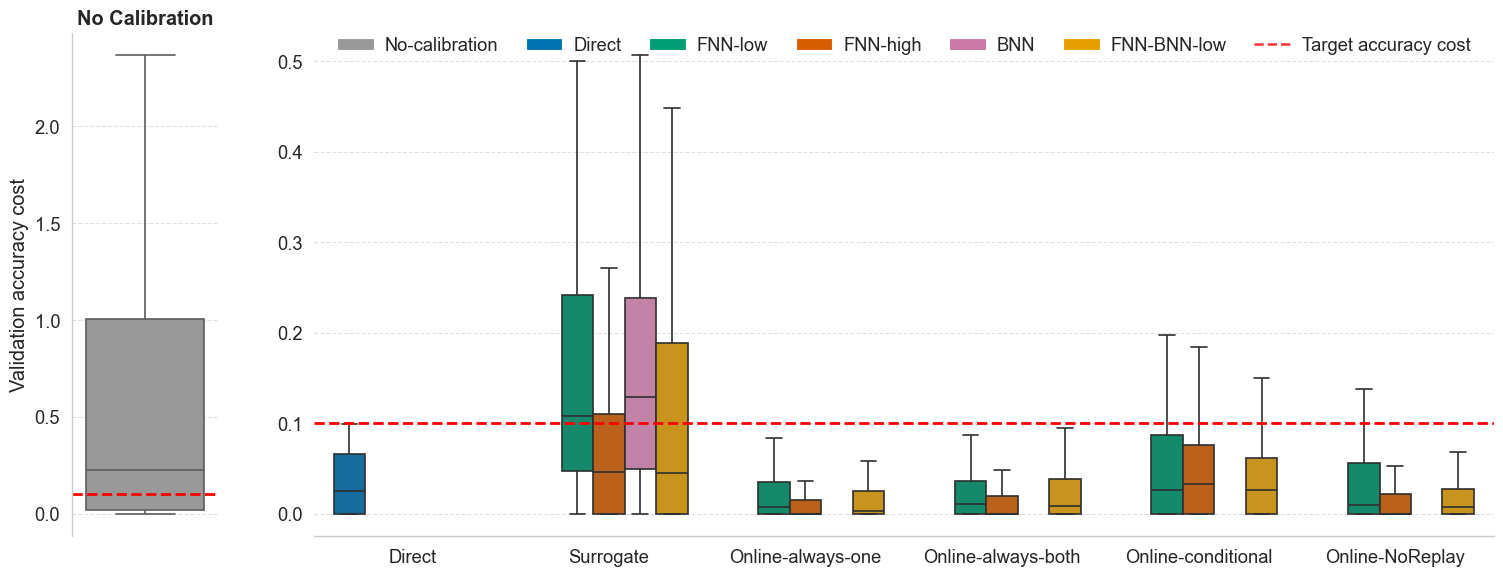

In [7]:


# Collect calibration cost data except No-Calibration and Online-NoReplay for right plot
cost_data = []
for case in cases_list:
    try:
        df = pd.read_excel(case['resultfile'], index_col=0)
        if case['CaseName'] not in ['No-Calibration']:
            for cost in df['Validation_Base_SimCost']:
                cost_data.append({
                    'Case': case['CaseName'],
                    'Model type': case['Type'],
                    'Calibration Cost': cost
                })
    except Exception as e:
        print(f"Could not load {case['resultfile']}: {e}")

cost_df = pd.DataFrame(cost_data)

# Prepare data for left subplot: only No-Calibration, no hue
no_calib_data = []
for case in cases_list:
    if case['CaseName'] == 'No-Calibration':
        try:
            df = pd.read_excel(case['resultfile'], index_col=0)
            for cost in df['Validation_Base_SimCost']:
                no_calib_data.append(cost)
        except Exception as e:
            print(f"Could not load {case['resultfile']}: {e}")

# --- Plotting ---

sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)

fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 8]})

# Left subplot: single boxplot for No-Calibration
sns.boxplot(
    y=no_calib_data,
    ax=ax_left,
    color='#999999',
    showfliers=False,
    linewidth=1.2
)
ax_left.set_title('No Calibration', weight='bold')
ax_left.set_ylabel('Validation accuracy cost')
ax_left.set_xticks([])
ax_left.axhline(0.1, color='red', linestyle='--', linewidth=2)  # same target line
ax_left.yaxis.grid(True, linestyle='--', alpha=0.6)
sns.despine(ax=ax_left, left=False, bottom=True)

# Right subplot: original boxplot with hue for other cases

model_type_palette = {
    'direct': '#0072B2',         # blue
    'FNN-low': '#009E73',  # green
    'FNN-high': '#D55E00',  # orange/red
    'BNN': '#CC79A7',
    'FNN-BNN-low': '#E69F00',
    'nocalibration' : '#999999',
}


cases = sorted(cost_df['Case'].unique(), key=list(cost_df['Case'].unique()).index)
model_types = sorted(cost_df['Model type'].unique(), key=list(cost_df['Model type'].unique()).index)

sns.boxplot(
    data=cost_df,
    x='Case',
    y='Calibration Cost',
    hue='Model type',
    palette=model_type_palette,
    order=cases,
    hue_order=model_types,
    showfliers=False,
    linewidth=1.2,
    ax=ax_right
)
ax_right.axhline(0.1, color='red', linestyle='--', linewidth=2)
#ax_right.set_title('Base calibration accuracy distribution by Method and Model Type', weight='bold')
ax_right.set_ylabel('')
ax_right.set_xlabel('')
ax_right.set_xticklabels(ax_right.get_xticklabels(), rotation=0, ha='center')
ax_right.yaxis.grid(True, linestyle='--', alpha=0.6)
sns.despine(ax=ax_right, left=True)

# Legend on right subplot
handles = [
    Patch(facecolor=model_type_palette['nocalibration'], label='No-calibration'),
    Patch(facecolor=model_type_palette['direct'], label='Direct'),
    Patch(facecolor=model_type_palette['FNN-low'], label='FNN-low'),
    Patch(facecolor=model_type_palette['FNN-high'], label='FNN-high'),
    Patch(facecolor=model_type_palette['BNN'], label='BNN'),
    Patch(facecolor=model_type_palette['FNN-BNN-low'], label='FNN-BNN-low'),
    Line2D([0], [0], color='red', linestyle='--', lw=1.8, alpha=0.8, label='Target accuracy cost')
]
ax_right.legend(
    handles=handles,
    #title='Model type',
    loc='upper center',
    bbox_to_anchor=(0.5, 1.025),
    ncol=len(handles),
    frameon=False,
    handletextpad=0.6,
    columnspacing=1.5
)

plt.tight_layout()
plt.show()


## Calibration Time 

In [8]:
direct_calibration_df = pd.read_excel('../03_Workflow_Calibration/Results/Direct/01_Calibration_direct.xlsx', index_col=0)

In [9]:
def add_direct_calibration_time(df, directdf):
    for k, item in df.iterrows():
        if not item['Validation_Base_Accurate']:
            df.loc[k, 'Calibration_Direct_EllapsedTime'] = directdf.loc[k, 'Calibration_Base_EllapsedTime']
    return df


# Calibration time (sec) by Method and Model Type

Could not load ../03_Workflow_Calibration/Results/00_No_Calibration.xlsx: "None of [Index(['Calibration_Base_EllapsedTime', 'Calibration_Direct_EllapsedTime'], dtype='object')] are in the [columns]"


C:\Users\pales\AppData\Local\Temp\ipykernel_28264\742985532.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')


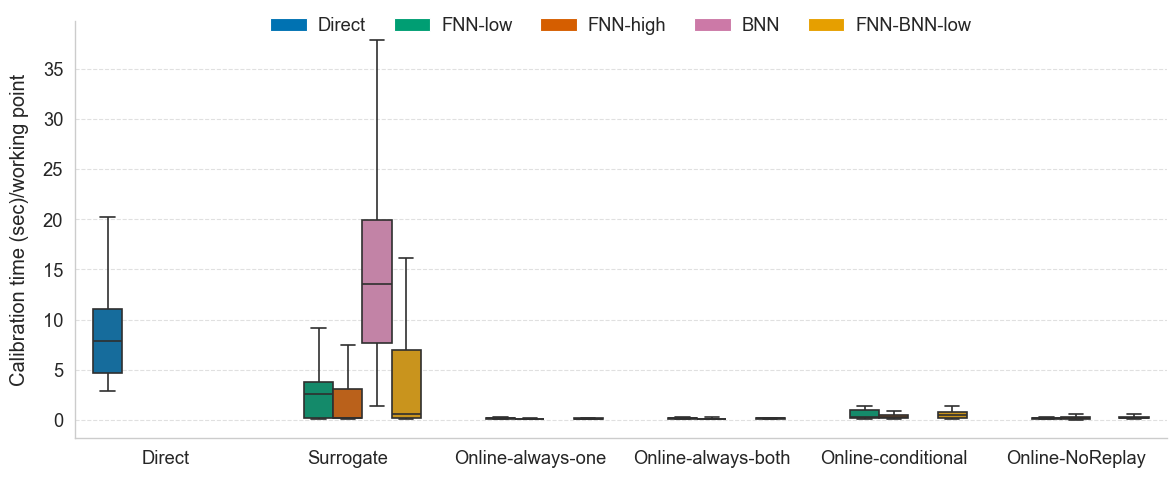

In [10]:
# Collect all costs into a single DataFrame
cost_data = []
for case in cases_list:
    try:
        df = pd.read_excel(case['resultfile'], index_col=0)
        if case['Type'] != 'BNN':
            for cost in df[['Calibration_Base_EllapsedTime', 'Calibration_Direct_EllapsedTime']].sum(axis=1):
                cost_data.append({
                    'Case': case['CaseName'],
                    'Model type': case['Type'],
                    'Calibration time': cost
                })
        if case['CaseName'] == 'Surrogate' and case['Type'] == 'BNN':
            add_direct_calibration_time(df, direct_calibration_df)
            for cost in df[['Calibration_Base_EllapsedTime', 'Calibration_Direct_EllapsedTime']].sum(axis=1):
                cost_data.append({
                    'Case': case['CaseName'],
                    'Model type': case['Type'],
                    'Calibration time': cost
                })
    except Exception as e:
        print(f"Could not load {case['resultfile']}: {e}")

cost_df = pd.DataFrame(cost_data)

# Modern style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 5))
sns.set_context("paper", font_scale=1.5)  # good for scientific figures

# Color palette
model_type_palette = {
    'direct': '#0072B2',         # blue
    'FNN-low': '#009E73',  # green
    'FNN-high': '#D55E00',  # orange/red
    'BNN': '#CC79A7',
    'FNN-BNN-low': '#E69F00',
    'nocalibration' : '#999999',
}

# Boxplot
ax = sns.boxplot(
    data=cost_df,
    x='Case',
    y='Calibration time',
    hue='Model type',
    palette=model_type_palette,
    showfliers=False,
    linewidth=1.2
)


# Custom legend: "Model type" inline
handles = [
    #Patch(facecolor='none', edgecolor='none', label='Model type:'),
    Patch(facecolor=model_type_palette['direct'], label='Direct'),
    Patch(facecolor=model_type_palette['FNN-low'], label='FNN-low'),
    Patch(facecolor=model_type_palette['FNN-high'], label='FNN-high'),
    Patch(facecolor=model_type_palette['BNN'], label='BNN'),
    Patch(facecolor=model_type_palette['FNN-BNN-low'], label='FNN-BNN-low'),
]
ax.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=len(handles),
    frameon=False,
    handletextpad=0.6,
    columnspacing=1.5
)

# Titles and labels
#ax.set_title('Calibration time (sec) by Method and Model Type', pad=15, weight='bold')
ax.set_ylabel('Calibration time (sec)/working point', labelpad=10)
ax.set_xlabel('')

# X-tick rotation
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

# Clean up style
sns.despine()
ax.yaxis.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## Number of direct simulation call

In [11]:
def add_direct_calibration_cost(df, directdf):
    for k, item in df.iterrows():
        if not item['Validation_Base_Accurate']:
            df.loc[k, 'Calibration_Direct_SimCost'] = directdf.loc[k, 'Validation_Base_SimCost']
    return df

Could not load ../03_Workflow_Calibration/Results/00_No_Calibration.xlsx: 'Calibration_Direct_SimCost'


C:\Users\pales\AppData\Local\Temp\ipykernel_28264\924615836.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')


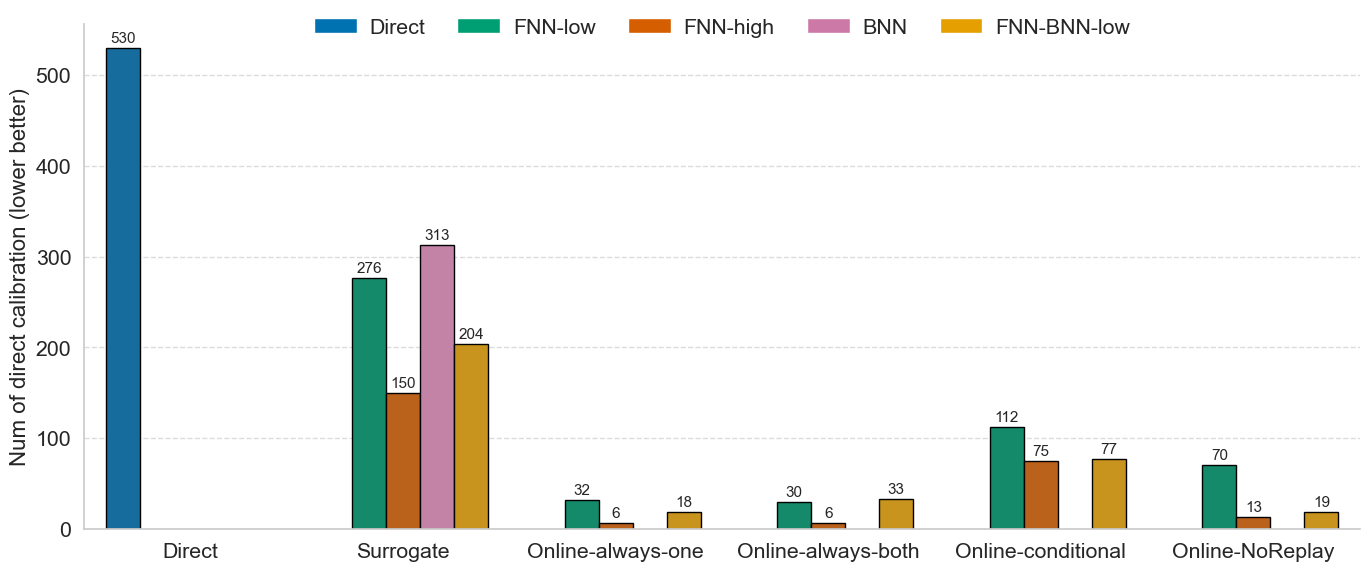

In [12]:
# Collect all costs into a single DataFrame
cost_data = []
for case in cases_list:
    try:
        df = pd.read_excel(case['resultfile'], index_col=0)
        if case['CaseName'] == 'Surrogate' and case['Type'] == 'BNN':
            add_direct_calibration_cost(df, direct_calibration_df)
        if case['Type'] == 'direct':
            count = len(df['Calibration_Direct_SimCost'])
        else:
            count = df['Calibration_Direct_SimCost'].notna().sum()
        cost_data.append({
            'Case': case['CaseName'],
            'Model type': case['Type'],
            'Direct calibration': count
        })
    except Exception as e:
        print(f"Could not load {case['resultfile']}: {e}")

cost_df = pd.DataFrame(cost_data)

# Set style and font
sns.set_theme(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(14, 6))

# Use colorblind-friendly palette
model_type_palette = {
    'direct': '#0072B2',         # blue
    'FNN-low': '#009E73',  # green
    'FNN-high': '#D55E00',  # orange/red
    'BNN': '#CC79A7',
    'FNN-BNN-low': '#E69F00',
    'nocalibration' : '#999999',
}

# Draw barplot
ax = sns.barplot(
    data=cost_df,
    x='Case',
    y='Direct calibration',
    hue='Model type',
    palette=model_type_palette,
    edgecolor='black'
)

# Add value labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=2, fontsize=11)


# Custom legend: "Model type" inline
handles = [
    #Patch(facecolor='none', edgecolor='none', label='Model type:'),
    Patch(facecolor=model_type_palette['direct'], label='Direct'),
    Patch(facecolor=model_type_palette['FNN-low'], label='FNN-low'),
    Patch(facecolor=model_type_palette['FNN-high'], label='FNN-high'),
    Patch(facecolor=model_type_palette['BNN'], label='BNN'),
    Patch(facecolor=model_type_palette['FNN-BNN-low'], label='FNN-BNN-low'),
]
ax.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=len(handles),
    frameon=False,
    handletextpad=0.6,
    columnspacing=1.5
)


# Titles and labels
#ax.set_title('Num of direct calibration by method and model type', fontsize=18, pad=15)
ax.set_ylabel('Num of direct calibration (lower better)', fontsize=16)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

# Remove top/right spines and add gridlines
sns.despine()
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Local calibration improvement by Method and Model Type

C:\Users\pales\AppData\Local\Temp\ipykernel_28264\695218107.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')


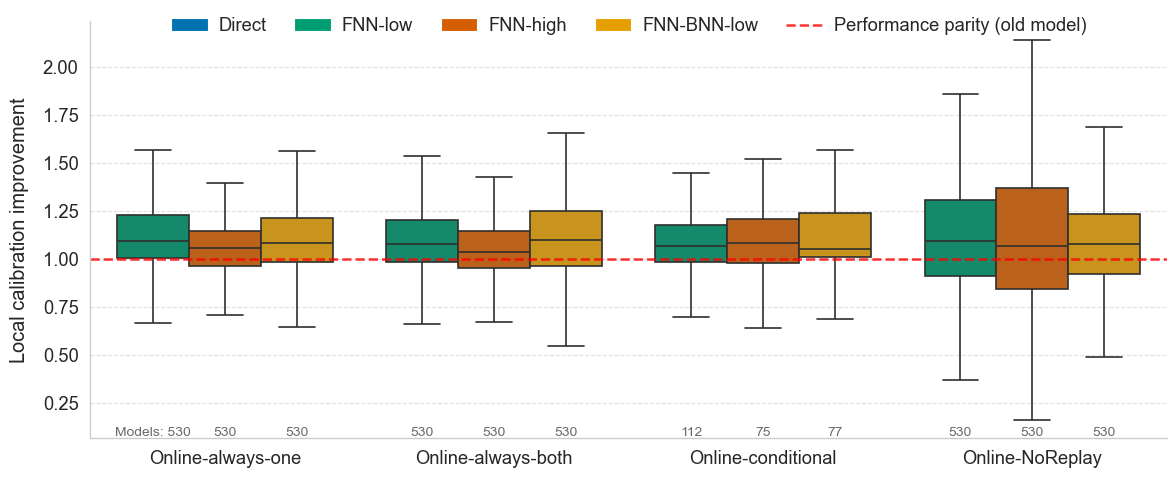

In [13]:
# Collect all costs into a single DataFrame
cost_data = []
model_versions = {}  # Store model_version_num for each (Case, Model type)
for case in cases_list:
    try:
        df = pd.read_excel(case['resultfile'], index_col=0)

        if case['CaseName'].startswith("Online"):
            model_version_num = len(df['New_Surrogate_version'].unique())
            model_versions[(case['CaseName'], case['Type'])] = model_version_num
            for cost in df['LocalImprovement']:
                cost_data.append({
                    'Case': case['CaseName'],
                    'Model type': case['Type'],
                    'LocalImprovement': cost
                })
    except Exception as e:
        print(f"Could not load {case['resultfile']}: {e}")

cost_df = pd.DataFrame(cost_data)

# Modern style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 5))
sns.set_context("paper", font_scale=1.5)  # good for scientific figures

# Color palette
model_type_palette = {
    'direct': '#0072B2',         # blue
    'FNN-low': '#009E73',  # green
    'FNN-high': '#D55E00',  # orange/red
    'BNN': '#CC79A7',
    'FNN-BNN-low': '#E69F00',
    'nocalibration' : '#999999',
}

# Explicit order
cases = sorted(cost_df['Case'].unique(), key=list(cost_df['Case'].unique()).index)
model_types = sorted(cost_df['Model type'].unique(), key=list(cost_df['Model type'].unique()).index)


# Boxplot
ax = sns.boxplot(
    data=cost_df,
    x='Case',
    y='LocalImprovement',
    hue='Model type',
    palette=model_type_palette,
    showfliers=False,
    linewidth=1.2
)

# Horizontal "ideal" line
target_cost = 1
ax.axhline(target_cost, color='red', linestyle='--', linewidth=1.8, alpha=0.8)

# Custom legend: "Model type" inline
handles = [
    #Patch(facecolor='none', edgecolor='none', label='Model type:'),
    Patch(facecolor=model_type_palette['direct'], label='Direct'),
    Patch(facecolor=model_type_palette['FNN-low'], label='FNN-low'),
    Patch(facecolor=model_type_palette['FNN-high'], label='FNN-high'),
    Patch(facecolor=model_type_palette['FNN-BNN-low'], label='FNN-BNN-low'),
    Line2D([0], [0], color='red', linestyle='--', lw=1.8, alpha=0.8, label='Performance parity (old model)')
]
ax.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=len(handles),
    frameon=False,
    handletextpad=0.6,
    columnspacing=1.5
)

# Place model counts below each group
n_hue = len(model_types)
bias = 0.03 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # small vertical offset
ii = 0
for i_case, case in enumerate(cases):
    for i_hue, model_type in enumerate(model_types):
        key = (case, model_type)
        if key in model_versions:
            x = i_case - 0.4 + (i_hue + 0.5) * 0.8 / n_hue
            if ii == 0:
                titlet = 'Models: '
            else:
                titlet = ''
            ax.text(
                x, 0 + bias,
                f"{titlet}{model_versions[key]}", ha='center', va='bottom', fontsize=10, color='dimgray'
            )
            ii += 1

# Titles and labels
#ax.set_title('Local calibration improvement by Method and Model Type', pad=15, weight='bold')
ax.set_ylabel('Local calibration improvement', labelpad=10)
ax.set_xlabel('')

# X-tick rotation
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

# Clean up style
sns.despine()
ax.yaxis.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Global accuracy retention by Method and Model Type

C:\Users\pales\AppData\Local\Temp\ipykernel_28264\1291364428.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')


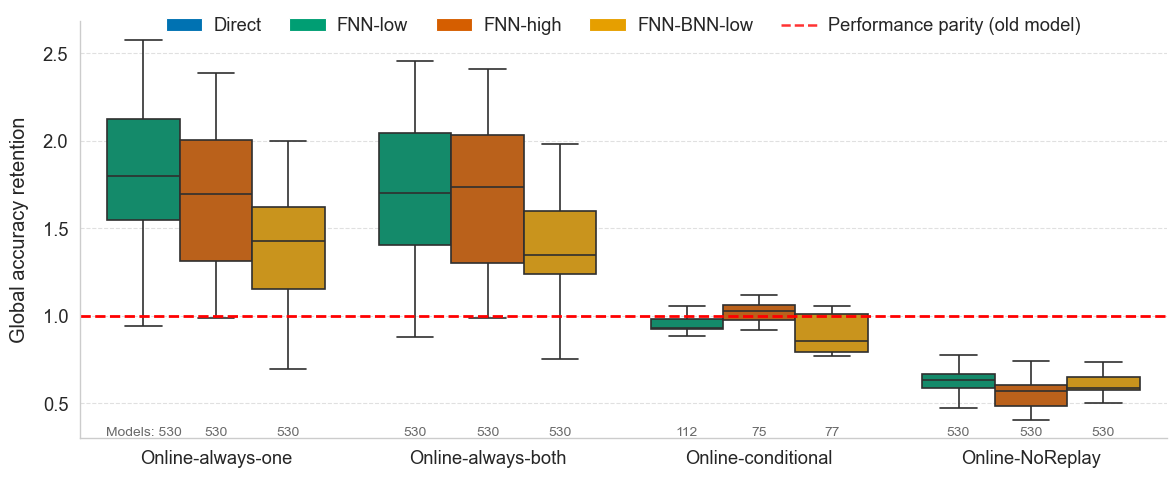

In [14]:
# Collect all costs into a single DataFrame
cost_data = []
model_versions = {}  # Store model_version_num for each (Case, Model type)
for case in cases_list:
    try:
        df = pd.read_excel(case['resultfile'], index_col=0)

        if case['CaseName'].startswith("Online"):
            model_version_num = len(df['New_Surrogate_version'].unique())
            model_versions[(case['CaseName'], case['Type'])] = model_version_num
            for cost in df['GlobalRetention']:
                cost_data.append({
                    'Case': case['CaseName'],
                    'Model type': case['Type'],
                    'GlobalRetention': cost
                })
    except Exception as e:
        print(f"Could not load {case['resultfile']}: {e}")

cost_df = pd.DataFrame(cost_data)

# Modern style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 5))
sns.set_context("paper", font_scale=1.5)  # good for scientific figures

# Color palette
model_type_palette = {
    'direct': '#0072B2',         # blue
    'FNN-low': '#009E73',  # green
    'FNN-high': '#D55E00',  # orange/red
    'BNN': '#CC79A7',
    'FNN-BNN-low': '#E69F00',
    'nocalibration' : '#999999',
}
# Explicit order
cases = sorted(cost_df['Case'].unique(), key=list(cost_df['Case'].unique()).index)
model_types = sorted(cost_df['Model type'].unique(), key=list(cost_df['Model type'].unique()).index)

# Boxplot
ax = sns.boxplot(
    data=cost_df,
    x='Case',
    y='GlobalRetention',
    hue='Model type',
    palette=model_type_palette,
    showfliers=False,
    linewidth=1.2
)


# Add horizontal line for target validation accuracy cost
target_cost = 1 
ax.axhline(target_cost, color='red', linestyle='--', linewidth=2)
# Custom legend: "Model type" inline
handles = [
    #Patch(facecolor='none', edgecolor='none', label='Model type:'),
    Patch(facecolor=model_type_palette['direct'], label='Direct'),
    Patch(facecolor=model_type_palette['FNN-low'], label='FNN-low'),
    Patch(facecolor=model_type_palette['FNN-high'], label='FNN-high'),
    Patch(facecolor=model_type_palette['FNN-BNN-low'], label='FNN-BNN-low'),
    Line2D([0], [0], color='red', linestyle='--', lw=1.8, alpha=0.8, label='Performance parity (old model)')
]
ax.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=len(handles),
    frameon=False,
    handletextpad=0.6,
    columnspacing=1.5
)

# Place model counts below each group
n_hue = len(model_types)
bias = 0.125 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # small vertical offset
ii = 0
for i_case, case in enumerate(cases):
    for i_hue, model_type in enumerate(model_types):
        key = (case, model_type)
        if key in model_versions:
            x = i_case - 0.4 + (i_hue + 0.5) * 0.8 / n_hue
            if ii == 0:
                titlet = 'Models: '
            else:
                titlet = ''
            ax.text(
                x, 0 + bias,
                f"{titlet}{model_versions[key]}", ha='center', va='bottom', fontsize=10, color='dimgray'
            )
            ii += 1

# Titles and labels
#ax.set_title('Global accuracy retention by Method and Model Type', pad=15, weight='bold')
ax.set_ylabel('Global accuracy retention', labelpad=10)
ax.set_xlabel('')

# X-tick rotation
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

# Clean up style
sns.despine()
ax.yaxis.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Visualization for one parameter

In [20]:
no_calibration_results = pd.read_excel('../03_Workflow_Calibration/Results/00_No_Calibration.xlsx', index_col=0)


# Calibration Accuracy Comparison for Key Output Parameters

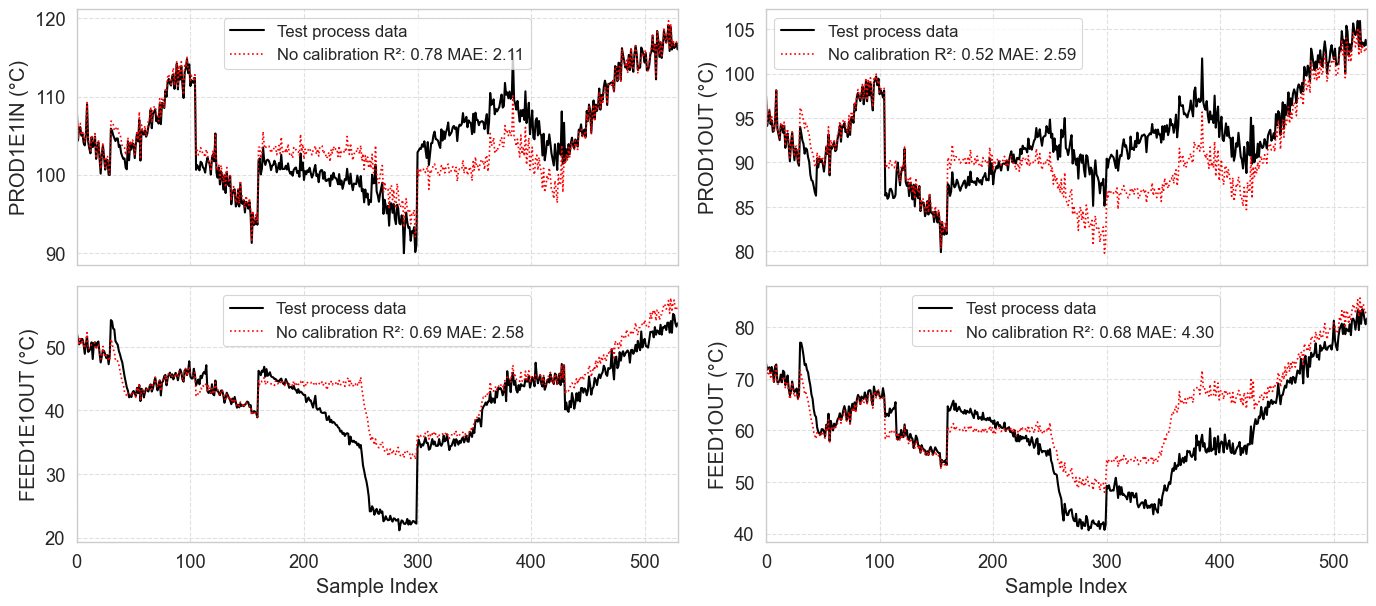

In [21]:

# --- Load and prepare data ---
dict_columns = ['Validation_Base_SimulationRes']
no_calibration_results = flatten_columns(no_calibration_results, dict_columns)
# Parameters and units
y_cols_dict = {'PROD1E1IN': '°C', 'PROD1OUT': '°C', 'FEED1E1OUT': '°C', 'FEED1OUT': '°C'}
num_cols = len(y_cols_dict)

fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True)
axes = axes.flatten()

for ax, (param, unit) in zip(axes, y_cols_dict.items()):
    col_base = 'Validation_Base_SimulationRes_' + param
    col_online = 'Validation_Base_SimulationRes_' + param
    

    # Metrics
    nocalib_r2 = r2_score(test_data[param], no_calibration_results[col_base])
    nocalib_mae = mean_absolute_error(test_data[param], no_calibration_results[col_base])

    
    # Plot process data
    ax.plot(test_data[param], label='Test process data', color='black', linewidth=1.5)
    
    # Plot no calibration
    ax.plot(no_calibration_results[col_base], label=f'No calibration R²: {nocalib_r2:.2f} MAE: {nocalib_mae:.2f}', linestyle='dotted', color='red')
    
    ax.set_ylabel(f"{param} ({unit})")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=12)
    ax.set_xlim([0, len(test_data)-1])

# X label only on bottom plots
for ax in axes[:2]:
    ax.set_xlabel('')
axes[2].set_xlabel("Sample Index")
axes[3].set_xlabel("Sample Index")

#plt.suptitle("Calibration Accuracy Comparison for Key Output Parameters", fontsize=16, weight='bold', y=0.93)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

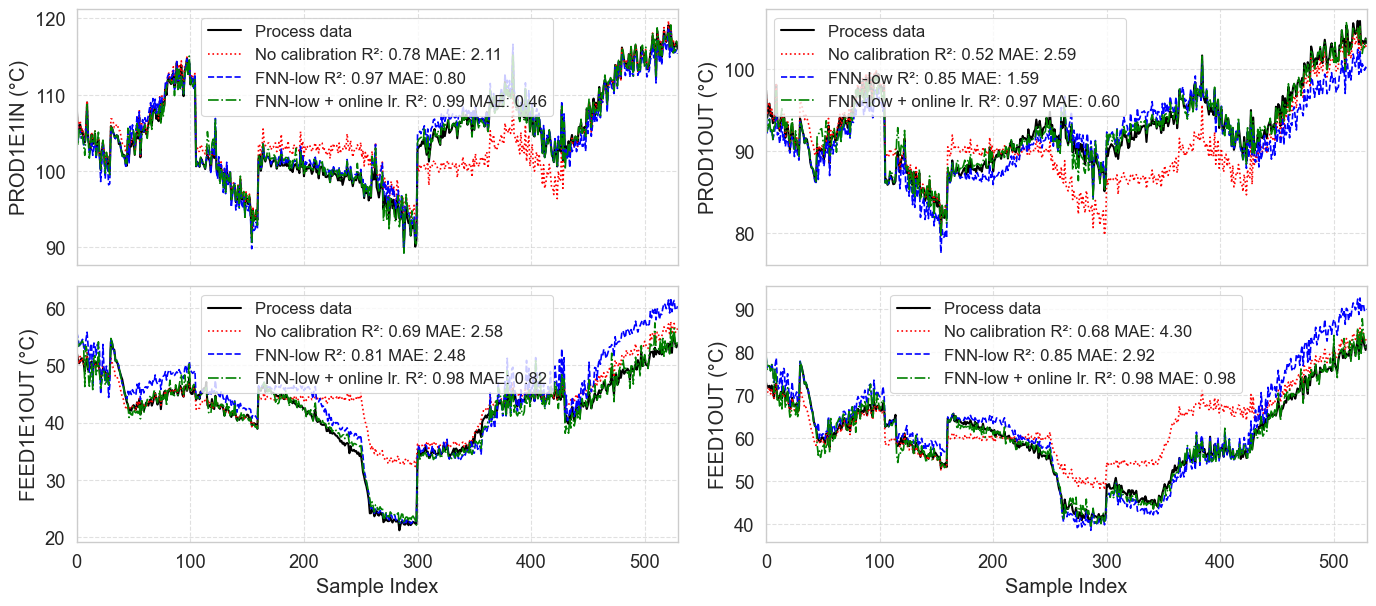

In [23]:

# --- Load and prepare data ---
dict_columns = ['Validation_Base_SimulationRes']

base_surrogate_df = pd.read_excel(cases_list[2]['resultfile'], index_col=0)
online_learning_df = pd.read_excel(cases_list[6]['resultfile'], index_col=0)


base_surrogate_df = flatten_columns(base_surrogate_df, dict_columns)
online_learning_df = flatten_columns(online_learning_df, dict_columns)

# Parameters and units
y_cols_dict = {'PROD1E1IN': '°C', 'PROD1OUT': '°C', 'FEED1E1OUT': '°C', 'FEED1OUT': '°C'}
num_cols = len(y_cols_dict)

fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True)
axes = axes.flatten()

for ax, (param, unit) in zip(axes, y_cols_dict.items()):
    col_base = 'Validation_Base_SimulationRes_' + param
    col_online = 'Validation_Base_SimulationRes_' + param
    
    # Adjust if format differs
    base_accurate = base_surrogate_df['Validation_Base_Accurate'].map(lambda x: x in [True, 'Yes', 'yes', 'TRUE', 'true'])
    online_accurate = online_learning_df['Validation_Base_Accurate'].map(lambda x: x in [True, 'Yes', 'yes', 'TRUE', 'true'])
    
    # Metrics
    nocalib_r2 = r2_score(test_data[param], no_calibration_results[col_base])
    nocalib_mae = mean_absolute_error(test_data[param], no_calibration_results[col_base])
    
    base_mae = mean_absolute_error(test_data[param], base_surrogate_df[col_base])
    base_r2 = r2_score(test_data[param], base_surrogate_df[col_base])
    
    online_mae = mean_absolute_error(test_data[param], online_learning_df[col_online])
    online_r2 = r2_score(test_data[param], online_learning_df[col_online])
    
    # Plot process data
    ax.plot(test_data[param], label='Process data', color='black', linewidth=1.5)
    
    # Plot no calibration
    ax.plot(no_calibration_results[col_base], label=f'No calibration R²: {nocalib_r2:.2f} MAE: {nocalib_mae:.2f}', linestyle='dotted', color='red')
    
    # Plot base surrogate
    ax.plot(base_surrogate_df[col_base], label=f'FNN-low R²: {base_r2:.2f} MAE: {base_mae:.2f}', linestyle='--', color='blue')
    
    # Plot online learning surrogate
    ax.plot(online_learning_df[col_online], label=f'FNN-low + online lr. R²: {online_r2:.2f} MAE: {online_mae:.2f}', linestyle='-.', color='green')
    '''
    # Highlight background where global accuracy is NOT good (invert accurate mask)
    for i in range(len(base_accurate)):
        if not base_accurate.iloc[i]:
            ax.axvspan(i - 0.5, i + 0.5, color='blue', alpha=0.1)
    for i in range(len(online_accurate)):
        if not online_accurate.iloc[i]:
            ax.axvspan(i - 0.5, i + 0.5, color='green', alpha=0.07)
    '''
    ax.set_ylabel(f"{param} ({unit})")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=12)
    ax.set_xlim([0, len(test_data)-1])

# X label only on bottom plots
for ax in axes[:2]:
    ax.set_xlabel('')
axes[2].set_xlabel("Sample Index")
axes[3].set_xlabel("Sample Index")

#plt.suptitle("Calibration Accuracy Comparison for Key Output Parameters", fontsize=16, weight='bold', y=0.93)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

In [24]:
# Parameters list
y_cols = ['PROD1E1IN', 'PROD1OUT', 'FEED1E1OUT', 'FEED1OUT']

metrics_list = []

for param in y_cols:
    col_base = 'Validation_Base_SimulationRes_' + param
    col_online = 'Validation_Base_SimulationRes_' + param

    # Calculate metrics for no calibration
    r2_nocalib = r2_score(test_data[param], no_calibration_results[col_base])
    mae_nocalib = mean_absolute_error(test_data[param], no_calibration_results[col_base])

    # Calculate metrics for base surrogate
    r2_base = r2_score(test_data[param], base_surrogate_df[col_base])
    mae_base = mean_absolute_error(test_data[param], base_surrogate_df[col_base])

    # Calculate metrics for online learning surrogate
    r2_online = r2_score(test_data[param], online_learning_df[col_online])
    mae_online = mean_absolute_error(test_data[param], online_learning_df[col_online])

    # Append results as a dict
    metrics_list.append({
        'Parameter': param,
        'No Calibration R²': r2_nocalib,
        'Base Surrogate R²': r2_base,
        'Online Learning R²': r2_online,
        'No Calibration MAE': mae_nocalib,
        'Base Surrogate MAE': mae_base,
        'Online Learning MAE': mae_online
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Optional: format values for better readability
metrics_df_formatted = metrics_df.copy()
for col in metrics_df.columns[1:]:
    metrics_df_formatted[col] = metrics_df[col].apply(lambda x: f"{x:.3f}")

metrics_df_formatted.T

,0,1,2,3
Parameter,PROD1E1IN,PROD1OUT,FEED1E1OUT,FEED1OUT
No Calibration R²,0.781,0.518,0.691,0.682
Base Surrogate R²,0.974,0.845,0.812,0.846
Online Learning R²,0.988,0.973,0.979,0.982
No Calibration MAE,2.114,2.594,2.579,4.302
Base Surrogate MAE,0.796,1.595,2.483,2.915
Online Learning MAE,0.456,0.596,0.819,0.981
